In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict, OrderedDict
from tqdm import tqdm_notebook as tqdm, tnrange as trange

plt.style.use('seaborn')

## Data

In [2]:
def parse(train_filename):
    with open(train_filename, 'r') as f:
        lines = f.readlines()

    observations, states = defaultdict(int), defaultdict(int)
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            obs, state = data_split
            observations[obs.lower()] += 1
            states[state] += 1
    return observations, states

In [3]:
def read_train_file(train_filename):
    with open(train_filename, 'r') as f:
        lines = f.readlines()
        
    sentence, label = [], []
    sentences, labels = [], []
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            word, state = data_split
            sentence.append(word)
            label.append(state)
        else:
            sentences.append(sentence)
            labels.append(label)
            sentence = []
            label = []
    return sentences, labels


def read_val_file(val_filename):
    with open(val_filename, 'r') as f:
        lines = f.readlines()
        
    sentence = []
    sentences = []
    for word in lines:
        if word == '\n':
            sentences.append(sentence)
            sentence = []
        else:
            sentence.append(word.strip().lower())
    return sentences

### Train data

In [4]:
dataset = 'EN'
train_filename = f'data/{dataset}/train'

observations, states = parse(train_filename)

In [5]:
train_sentences, train_labels = read_train_file(train_filename)
train_sentences[0][:5], train_labels[0][:5]

(['RT', '@shaunproulx', ':', 'Encore', '!'], ['O', 'O', 'O', 'B-INTJ', 'O'])

### Validation data

In [6]:
val_filename = f'data/{dataset}/dev.in'
val_sentences = read_val_file(val_filename)
val_sentences[0][:5]

['no', 'saints', 'r', '.', 'buch']

## Encoding

In [7]:
def one_hot_encode(n, depth):
    a = np.zeros([depth, 1])
    a[n, 0] = 1
    return a

### Encode words
Create a vocabulary out of words that appear more than `1` time(s) in training. Each word now maps to an _integer_. Other words will be treated as `#UNK#`.

In [8]:
token_mapping = {}
for word in observations:
    if observations[word] > 1:  # appears more than once in training
        token_mapping[word] = len(token_mapping)
token_mapping['#UNK#'] = len(token_mapping)
len(token_mapping)

878

In [9]:
def tokenize(token_mapping, sentence):
    """
    Function to convert each word into its corresponding integer
    If word is not found, return the value for '#UNK'
    """
    return [token_mapping.get(w, token_mapping['#UNK#']) for w in sentence]

tokens = [tokenize(token_mapping, sentence) for sentence in train_sentences]
tokens[0][:5]

[877, 877, 1, 877, 2]

Tokenize then one-hot-encode each sentence.

In [10]:
inputs = [[one_hot_encode(token, len(token_mapping)) for token in sentence] for sentence in tokens]
inputs = [np.asarray(ls) for ls in inputs]
len(inputs), inputs[0].shape

(551, (25, 878, 1))

### Encode labels
Perform a similar encoding for the states:
1. Map to integer
1. Convert from integer to one-hot-encoding

In [11]:
state_mapping = {state: i for i, state in enumerate(states)}
state_mapping

{'O': 0,
 'B-INTJ': 1,
 'B-PP': 2,
 'B-NP': 3,
 'I-NP': 4,
 'B-VP': 5,
 'B-PRT': 6,
 'I-VP': 7,
 'B-ADJP': 8,
 'B-SBAR': 9,
 'B-ADVP': 10,
 'I-INTJ': 11,
 'B-CONJP': 12,
 'I-CONJP': 13,
 'I-ADVP': 14,
 'I-ADJP': 15,
 'I-SBAR': 16,
 'I-PP': 17}

In [12]:
encoded_labels = [[state_mapping[state] for state in label] for label in train_labels]
encoded_labels[0][:5]

[0, 0, 0, 1, 0]

In [13]:
labels = [[one_hot_encode(label, len(state_mapping)) for label in sentence] for sentence in encoded_labels]
labels = [np.asarray(ls) for ls in labels]
len(labels), labels[0].shape

(551, (25, 18, 1))

## Perceptron

In [14]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

### Initialization

In [15]:
np.random.seed(0)
model = OrderedDict({
    'W1': np.random.normal(scale=0.1, size=[128, len(token_mapping)]),
    'W2': np.random.normal(scale=0.1, size=[128, 128]),
    'W3': np.random.normal(scale=0.1, size=[len(state_mapping), 128]),
})

In [16]:
x = inputs[0][0]
y = labels[0][0]
x.shape, y.shape

((878, 1), (18, 1))

In [17]:
a = np.array(list(states.values()))
a

array([2191,  257,  716, 2768, 1904, 1327,   85,  607,  159,   71,  386,
         88,    2,    2,   51,   61,    4,    6])

### Forward

In [18]:
def forward(model, x):
    a1 = model['W1'].dot(x)
    h1 = np.maximum(a1, 0)
    
    a2 = model['W2'].dot(h1)
    h2 = np.maximum(a2, 0)
    
    a3 = model['W3'].dot(h2)
    y_ = softmax(a3)
    return y_


def compute_loss(model, x, y):
    y_ = forward(model, x)
    xent = -np.log(y_ + 1e-8) * y
    return np.sum(xent)


compute_loss(model, x, y)

2.956598269877938

## Backward
`<insert derived backpropagation equations here>`

In [19]:
def compute_grad(model, x, y):
    # forward
    a1 = model['W1'].dot(x)
    h1 = np.maximum(a1, 0)
    
    a2 = model['W2'].dot(h1)
    h2 = np.maximum(a2, 0)
    
    a3 = model['W3'].dot(h2)
    y_ = softmax(a3)
    
    # backward
    d3 = y_ - y
    d2 = model['W3'].T.dot(d3) * (a2 * (a2 >= 0))
    d1 = model['W2'].T.dot(d2) * (a1 * (a1 >= 0))

    grad_W1 = d1.dot(x.T)
    grad_W2 = d2.dot(h1.T)
    grad_W3 = d3.dot(h2.T)
    
    assert grad_W1.shape == model['W1'].shape
    assert grad_W2.shape == model['W2'].shape
    assert grad_W3.shape == model['W3'].shape
    
    grad = OrderedDict({
        'W1': grad_W1,
        'W2': grad_W2,
        'W3': grad_W3,
    })
    return grad

grad = compute_grad(model, x, y)
for k in grad:
    print(k, grad[k].shape, sep='\t')

W1	(128, 878)
W2	(128, 128)
W3	(18, 128)


## Training

In [20]:
lr = 0.01
n_epochs = 20

In [21]:
%%script false
# test loss function by overfitting
losses = []
for i in trange(n_iters):
    loss = compute_loss(W, b, x, y)
    grad_W = compute_grad_W(W, b, x, y)
    grad_b = compute_grad_b(W, b, x, y)
    
    W -= lr * grad_W
    b -= lr * grad_b
    losses.append(loss)

In [22]:
losses = []

for i in trange(n_epochs):
    for i in trange(len(inputs), leave=False):  # for each sentence
        loss = []  # average across each sentence
        grads = {'W1': [], 'W2': [], 'W3': []}
        for j in range(len(inputs[i])):  # for each word
            x = inputs[i][j]
            y = labels[i][j]
            
            loss.append(compute_loss(model, x, y))
            grad = compute_grad(model, x, y)
            for k in grad:
                grads[k].append(grad[k])
        
        for k in grads:
            model[k] -= lr * np.mean(grads[k], axis=0)
        losses.append(np.mean(loss))
    lr *= 0.9

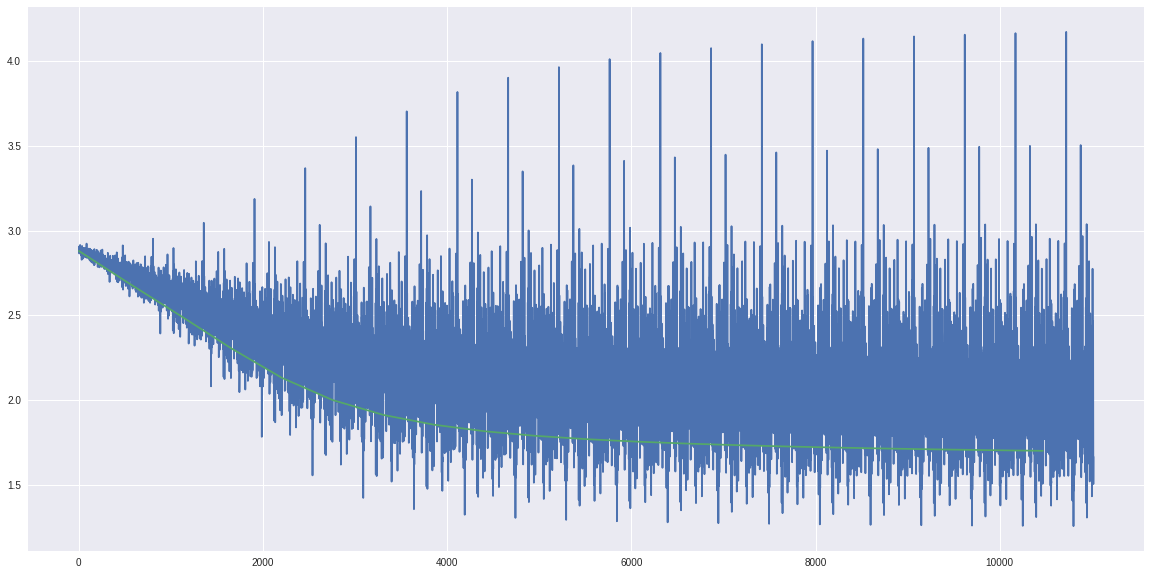

In [28]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(losses)), losses)  # overall training loss

interval = len(inputs)
plt.plot(np.arange(len(losses))[::interval], losses[::interval]);  # loss of one sentence over each epoch

In [24]:
# np.save('W_epochs20_lr0.1', W)
# np.save('b_epochs20_lr0.1', b)

## Prediction

In [25]:
out_filename = f'data/{dataset}/dev.p5.out'

In [26]:
def predict(model, sequence):
    states = list(state_mapping)
    
    result = []
    tokens = tokenize(token_mapping, sequence)
    for token in tokens:
        x = one_hot_encode(token, len(token_mapping))
        y_ = forward(model, x)
        pred = states[np.argmax(y_)]
        result.append(pred)
    return result
        
predict(model, val_sentences[0])

['B-NP',
 'B-NP',
 'B-NP',
 'O',
 'B-NP',
 'B-NP',
 'B-NP',
 'B-NP',
 'B-NP',
 'B-NP',
 'B-NP',
 'B-NP',
 'B-NP',
 'B-NP',
 'B-NP']

In [27]:
with open(out_filename, 'w') as f:
    for sentence in val_sentences:
        result = predict(model, sentence)
        
        for i in range(len(sentence)):
            word = sentence[i].strip()
            if word:
                f.write(word + ' ' + result[i])
            f.write('\n')

## RNN
$$
    a^{(t)} = b + Wh^{(t-1)} + Ux^{(t)} \\
    h^{(t)} = \text{tanh}(a^{(t)}) \\
    \\
    o^{(t)} = c + Vh^{(t)} \\
    \hat{y}^{(t)} = \text{softmax}(o^{(t)})
$$